<h3> Removing top layer of efficient net and loading our own classification layer</h3>

references:<br>
<a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/">Tensorflow Documentation - Layers</a><br>
<a href="https://arxiv.org/pdf/1905.11946.pdf">Efficient Net and how it works</a><br>
<a href="https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/">Keras example for fine tuning</a><br>
<a href="https://www.tensorflow.org/guide/keras/train_and_evaluate">Tensorflow Documentation - Compiling and Evaluating</a><br>
<a href="https://keras.io/api/optimizers/">Keras Documentation - Optimisers</a><br>
<a href="https://keras.io/api/metrics/">Keras Documentation - Metrics</a><br>
<a href="https://keras.io/api/losses/">Keras Documentation - Losses</a><br>



In [290]:
# importing required packages

from tensorflow.keras.applications import EfficientNetB0 as enet
from tensorflow.keras import models
from tensorflow.keras import layers
import tensorflow.keras as keras
import tensorflow as tf
import numpy as np
import matplotlib.pylab as plt

# from PIL import Image, ImageDraw

from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import Model 
from tensorflow.keras.optimizers import RMSprop

Preparing the Dataset
We will first prepare the dataset and separate out the images:

We first divide the folder contents into the train and validation directories.
Then, in each of the directories, create a separate directory for cats that contains only cat images, and a separate director for dogs having only dog images.

In [291]:
base_dir = '../data'
train_dir = os.path.join(base_dir, 'training')
validation_dir = os.path.join(base_dir, 'validation')

cwd = os.getcwd()
print(cwd)

/Users/majordomo/Documents/GitHub/AI-0403-Team-3/notebook


Step 1: Image Augmentation
Since we took up a much smaller dataset of images earlier, we can make up for it by augmenting this data and increasing our dataset size. If you are working with the original larger dataset, you can skip this step and move straight on to building the model.

In [292]:
# Add our data-augmentation parameters to ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255., rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1.0/255.)

train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 20, class_mode = 'binary', target_size = (224, 224))

validation_generator = test_datagen.flow_from_directory(validation_dir, batch_size = 20, class_mode = 'binary', target_size = (224, 224))


Found 2168 images belonging to 2 classes.
Found 401 images belonging to 2 classes.


Step 2: Loading the Base Model
We will be using the B0 version of EfficientNet since it is the simplest of the 8. I urge you to experiment with the rest of the models, though do keep in mind that the models go on becoming more and more complex, which might not be the best suited for a simple binary classification task.

In [293]:
# loading pretrained model, setting input shape
inputs = (224, 224, 3)

# Selecting a topless model (sounds damn good...)
basemodel = enet(include_top=False, input_shape=inputs, weights="imagenet")

# locking the trained weights (freezing?)
for layer in basemodel.layers:
    layer.trainable = False

# checking out how its like
basemodel.summary()

e_expand[0][0]          
__________________________________________________________________________________________________
block5b_project_conv (Conv2D)   (None, 14, 14, 112)  75264       block5b_se_excite[0][0]          
__________________________________________________________________________________________________
block5b_project_bn (BatchNormal (None, 14, 14, 112)  448         block5b_project_conv[0][0]       
__________________________________________________________________________________________________
block5b_drop (Dropout)          (None, 14, 14, 112)  0           block5b_project_bn[0][0]         
__________________________________________________________________________________________________
block5b_add (Add)               (None, 14, 14, 112)  0           block5b_drop[0][0]               
                                                                 block5a_project_bn[0][0]         
____________________________________________________________________________________

Step 3: Build the model
Just like Inceptionv3, we will perform these steps at the final layer:

In [294]:
# to rebuild top layer for our own classification

dropout_rate = 0.1 #i_dunno_yet - supposed to prevent overfit
types = 2 #currently only mask and no mask 

# building up the model in sequence
model = models.Sequential()

# loading the original topless model
model.add(basemodel)

# adding global pooling 2d to remove the columns and rows output from previous layer
# model.add(layers.GlobalMaxPooling2D(name="gmp"))

model.add(layers.GlobalAveragePooling2D(name="gap"))
# adding the dropout and subsequently the softmax layer
# model.add(layers.Dropout(dropout_rate, name="drout"))

model.add(layers.Dense(1024,activation=('relu'), name="relu1024",input_dim=512))

#  ADDED
model.add(layers.Dense(512,activation=('relu'), name="relu512")) 
model.add(layers.Dense(256,activation=('relu'), name="relu256")) 
#model.add(layers.Dropout(dropout_rate, name="drout"))
model.add(layers.Dense(128,activation=('relu'), name="relu128"))
#model.add(layers.Dropout(dropout_rate, name="drout"))
#model.add(layers.Dense(10,activation=('softmax'))) 
#model.add(layers.Dense(types, activation="softmax", name="classdense"))

# view the assembled model
# model.summary()

In [295]:


x = model.output
# x = layers.Flatten()(x)
x = layers.Dense(1024, activation="relu")(x)
# x = layers.Dropout(0.1)(x)

predictions = layers.Dense(1, activation="sigmoid")(x)
model_final = Model(model.input, predictions)

Step 4: Compile and Fit
Let us again use the RMSProp Optimiser, though here, I have introduced a decay parameter:

In [296]:
model_final.summary()

Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0_input (InputL [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
gap (GlobalAveragePooling2D) (None, 1280)              0         
_________________________________________________________________
relu1024 (Dense)             (None, 1024)              1311744   
_________________________________________________________________
relu512 (Dense)              (None, 512)               524800    
_________________________________________________________________
relu256 (Dense)              (None, 256)               131328    
_________________________________________________________________
relu128 (Dense)              (None, 128)               328

We finally fit the model on our data:

In [297]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['accuracy'])
    self.model.reset_metrics()

batch_stats_callback = CollectBatchStats()



In [298]:
class LossAndErrorPrintingCallback(keras.callbacks.Callback):
    def on_train_batch_end(self, batch, logs=None):
        print("For batch {}, loss is {:7.2f}.".format(batch, logs["loss"]))

    def on_test_batch_end(self, batch, logs=None):
        print("For batch {}, loss is {:7.2f}.".format(batch, logs["loss"]))

    def on_epoch_end(self, epoch, logs=None):
        print(
            "The average loss for epoch {} is {:7.2f} "
            "and mean absolute error is {:7.2f}.".format(
                epoch, logs["loss"], logs["mean_absolute_error"]
            )
        )
loss_and_error_printing_callback = LossAndErrorPrintingCallback()

In [299]:
model_final.compile(RMSprop(lr=0.0001, decay=1e-6),loss='binary_crossentropy',metrics=['accuracy'])
# model_final.compile(RMSprop(lr=0.001, decay=1e-5),loss='mse',metrics=['accuracy'])
# to compile the model (specifying optimser, loss and metrics) - I_dunno_need_adj_later

# model_final.compile(optimizer=keras.optimizers.Adadelta(learning_rate=0.001, rho=0.95, epsilon=1e-07), loss=keras.losses.SparseCategoricalCrossentropy(), metrics=[keras.metrics.SparseCategoricalAccuracy()])

In [300]:
eff_history = model_final.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 32, epochs = 10, callbacks=[batch_stats_callback])
# eff_history = model_final.fit_generator(train_generator, validation_data = validation_generator, steps_per_epoch = 100, epochs = 10)

Epoch 1/10
32/32 [==============================] - 60s 2s/step - loss: 0.6926 - accuracy: 0.5182 - val_loss: 0.6594 - val_accuracy: 0.7506
Epoch 2/10
32/32 [==============================] - 42s 1s/step - loss: 0.6908 - accuracy: 0.5439 - val_loss: 0.6533 - val_accuracy: 0.7506
Epoch 3/10
32/32 [==============================] - 39s 1s/step - loss: 0.6939 - accuracy: 0.5152 - val_loss: 0.6762 - val_accuracy: 0.7506
Epoch 4/10
32/32 [==============================] - 49s 2s/step - loss: 0.6935 - accuracy: 0.5091 - val_loss: 0.7114 - val_accuracy: 0.2494
Epoch 5/10
32/32 [==============================] - 46s 1s/step - loss: 0.6940 - accuracy: 0.5083 - val_loss: 0.6926 - val_accuracy: 0.7506
Epoch 6/10
32/32 [==============================] - 46s 1s/step - loss: 0.6935 - accuracy: 0.4970 - val_loss: 0.6900 - val_accuracy: 0.7506
Epoch 7/10
32/32 [==============================] - 43s 1s/step - loss: 0.6929 - accuracy: 0.5288 - val_loss: 0.6853 - val_accuracy: 0.7506
Epoch 8/10
32/32 [==

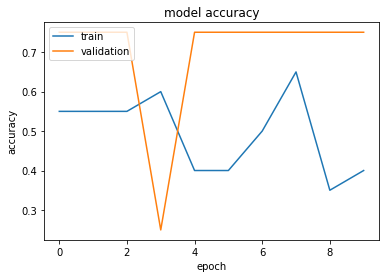

In [301]:
# to-do: fit the training set into the fine-tuned model to see if theres improvements
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(eff_history)

In [302]:
# to-do: process validation data and validate model with validation data set


In [303]:
# to-do: write entry script for web api


In [304]:
# to-do: packing up the model (docker) and deploy (it will be a nightmare)


In [305]:
# to-do: deploy model on cloud space, verify service is running


In [306]:
# to-do: test model (and profit)
